## Simulator


In [2]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100


class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## UNet

In [3]:
# Original linear network

Nbins = len(freq)
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Sequential(torch.nn.Linear(Nbins, 2048),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(2048),
                                               torch.nn.Linear(2048, 512),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(512),
                                               torch.nn.Linear(512, 256),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(256),
                                               torch.nn.Linear(256, 128),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(128),
                                               torch.nn.Linear(128, 32),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(32),
                                               torch.nn.Linear(32, 8),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(8),
                                              )
        self.summarizer = torch.nn.Linear(Nbins, 16)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features=16, num_params=2, varnames='z')
        
    def forward(self, A, B):
        s = self.summarizer(A['x'])
        logratios = self.logratios(s, B['z'])
#         logratios = self.logratios(A['x'], B['z'])
#         s = self.summarizer(A['x'])
#         s = s.unsqueeze(-1)
        return logratios #self.logratios(s, B['z']), s

In [4]:
# Redefine with self.summarizer as unet function
# Need to debug forward function

import torch
import torch.nn as nn
import swyft

def unet(in_channels, out_channels):
    encoder = nn.Sequential(
        nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        #nn.BatchNorm1d(64),
        #nn.MaxPool1d(2),
        #nn.Conv1d(64, 128, kernel_size=3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm1d(128),
        #nn.MaxPool1d(2),
        #nn.Conv1d(128, 256, kernel_size=3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm1d(256),
        #nn.MaxPool1d(2),
    )

    bottleneck = nn.Sequential(
        nn.Conv1d(64, 64, kernel_size=3, padding=1),  # Adjust the channels as needed
        nn.ReLU(),
        nn.Flatten()
        #nn.BatchNorm1d(64),
    )

   #decoder = nn.Sequential(
        #nn.Conv1d(256, 128, kernel_size=3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm1d(128),
        #nn.Conv1d(128, 64, kernel_size=3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm1d(64),
        #nn.Conv1d(64, 32, kernel_size=3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm1d(32),
       # nn.ConvTranspose1d(64, out_channels, kernel_size=3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm1d(64),
    #)

    return nn.Sequential(encoder, bottleneck)


class Network(swyft.SwyftModule):
    def __init__(self, in_channels, out_channels):
        super(Network, self).__init__()

        self.summarizer = unet(in_channels, out_channels)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features=2, num_params=2, varnames='z')

    def forward(self, A, B): # I think the error is here
        s = self.summarizer(A['x'])
        logratios = self.logratios(s, B['z'])
        return logratios



In [5]:
# Torch Summary
from torchsummary import summary

Nbins = len(freq) 
in_channels =  1
out_channels = 1
network = unet(in_channels,out_channels)

summary(network, input_size=(1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 64]             256
              ReLU-2               [-1, 64, 64]               0
            Conv1d-3               [-1, 64, 64]          12,352
              ReLU-4               [-1, 64, 64]               0
           Flatten-5                 [-1, 4096]               0
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.05
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [6]:
# Fake data to check shape

fake_input = torch.randn(1, 1, 64)  # Assuming 64 time steps
model = unet(in_channels=1, out_channels=1)
# Print the output shape for verification
print("Fake Input Shape:", fake_input.shape)
output = model(fake_input)
print("Output Shape:", output.shape)

Fake Input Shape: torch.Size([1, 1, 64])
Output Shape: torch.Size([1, 4096])


## Visualising Simulated Data

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2716.59it/s]


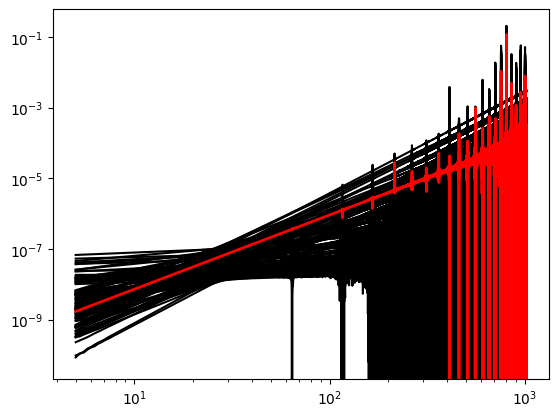

In [7]:
fref = 25
CE_PSD = np.genfromtxt("cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)
for i in range(len(samples)):
    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

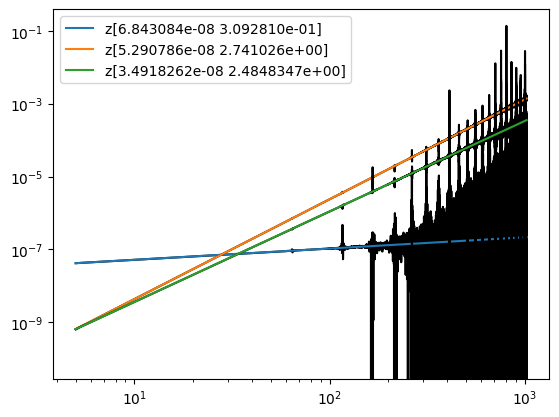

In [8]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

## PCA

100%|██████████| 20000/20000 [00:06<00:00, 2932.27it/s]


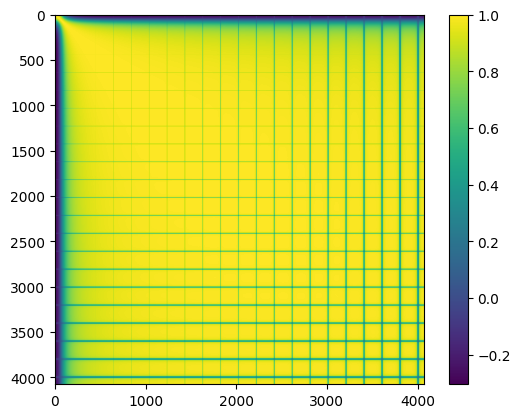

In [24]:
samples = sim.sample(20000) # 20,000 samples
data = samples['x']
# RUN THIS
fig = plt.figure()
ax = fig.add_subplot(111)

corr = np.corrcoef(data,rowvar=False)

plt.imshow(corr)
plt.colorbar()

In [25]:
data.shape

(20000, 4076)

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10) 
pca.fit(data)
pca_components = pca.transform(data)

# Reconstruct the original features
reconstructed_data = pca.inverse_transform(pca_components)


In [27]:
pca_components.shape

(20000, 10)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_67452/488970560.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')


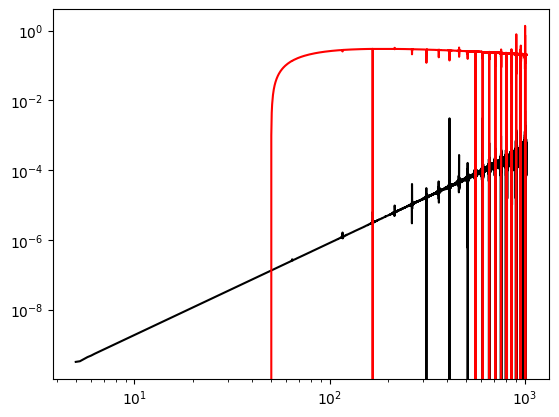

In [30]:
plt.loglog(sim.freq, data[100], 'k')
plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')

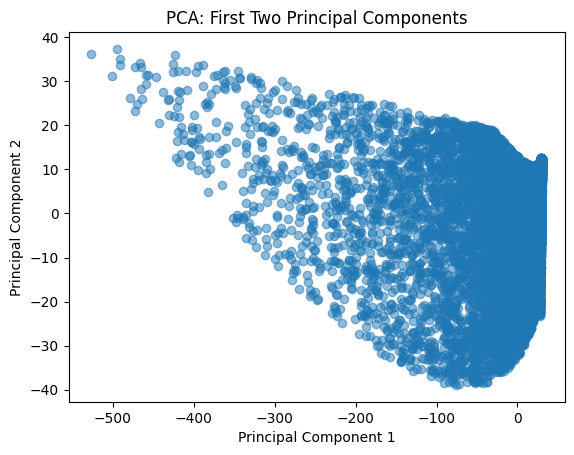

In [31]:
import matplotlib.pyplot as plt

# Assuming 'projected_data' contains the data projected onto the principal components
# If you haven't run the PCA steps from the previous response, make sure to do that first

# Extract the first two principal components
pc1 = projected_data[:, 0]
pc2 = projected_data[:, 1]

# Create a scatter plot
plt.scatter(pc1, pc2, alpha=0.5)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## ICA

In [32]:
import numpy as np
from sklearn.decomposition import FastICA

# Reduce from 4076 to 50 features

ica = FastICA(n_components=50)

ica.fit(data)

ica_components = ica.transform(data)

# Reconstruct data from independent components
reconstructed_data = ica.inverse_transform(ica_components)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


(20000, 50)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_67452/488970560.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')


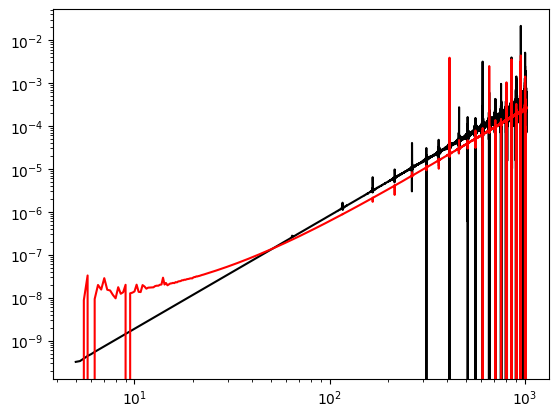

In [34]:
plt.loglog(sim.freq, data[100], 'k')
plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')

## Kernel PCA - rbf kernel

In [39]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1, fit_inverse_transform=True)  
kpca.fit(data)

kpca_components = kpca.transform(data)

reconstructed_data = kpca.inverse_transform(kpca_components)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_67452/488970560.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')


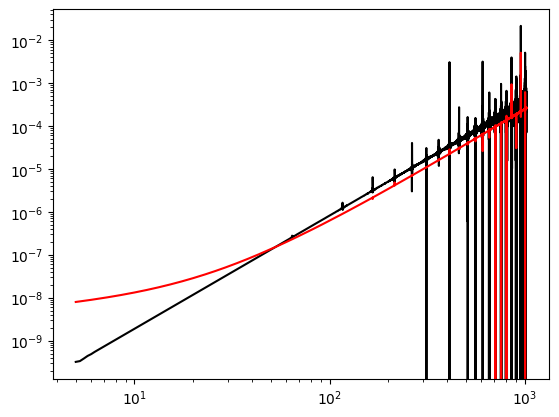

In [40]:
plt.loglog(sim.freq, data[100], 'k')
plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')

## Truncated SVD

In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10) 
svd.fit(data)
svd_components = svd.transform(data)

reconstructed_data = svd.inverse_transform(svd_components)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_67452/488970560.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')


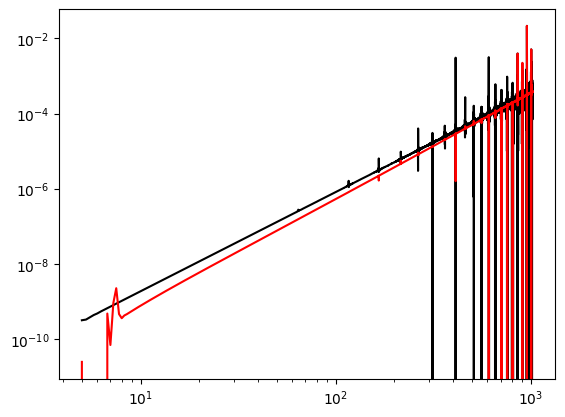

In [38]:
plt.loglog(sim.freq, data[100], 'k')
plt.loglog(sim.freq, reconstructed_data[100], 'k',c='r')

## Train Network

In [ ]:
#def round(obs, bounds=None):
    
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
samples = sim.sample(20000) #20000 training samples
dm = swyft.SwyftDataModule(samples, batch_size=32) #traing w samples
trainer = swyft.SwyftTrainer(accelerator="gpu", precision = 32)
   
network = Network()

trainer.fit(network, dm) #fit network

prior_samples = sim.sample(N = 10000, targets=['z']) #simulate ratio estimation
predictions = trainer.infer(network, obs, prior_samples) #predictions
new_bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold=1e-2) #set new bounds for priors
#return predictions, new_bounds, samples

100%|██████████| 20000/20000 [00:06<00:00, 2949.04it/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: Network.__init__() missing 2 required positional arguments: 'in_channels' and 'out_channels'

In [ ]:
T_obs

31536000